In [1]:
from openni import openni2
from openni import _openni2 as c_api
import numpy as np
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud as pc
import time

%matplotlib inline

Various setup variables

In [2]:
Depth_ResX = 512
Depth_ResY = 424
Depth_fps = 30
RGB_ResX = 512
RGB_ResY = 424
RGB_fps = 30

Initialize OpenNNI

In [3]:
openni2.initialize("/usr/lib")

Open a device, and get some info from it.

In [4]:
dev = openni2.Device.open_any()
print(dev.get_device_info())

OniDeviceInfo(uri = b'freenect2://0?serial=124535140947', vendor = b'Microsoft', name = b'Kinect', usbVendorId = 31136, usbProductId = 3460)


Create a depth stream

In [5]:
dev.set_image_registration_mode(True)
#dev.get_image_registration_mode()
#dev.depth_color_sync = True
#dev.get_image_registration_mode()
dev.set_depth_color_sync_enabled(True)

In [6]:
depth_stream = dev.create_depth_stream()
depth_stream.set_video_mode(c_api.OniVideoMode(pixelFormat=c_api.OniPixelFormat.ONI_PIXEL_FORMAT_DEPTH_1_MM,
                                               resolutionX=Depth_ResX,
                                               resolutionY=Depth_ResY,
                                               fps=Depth_fps,
                                              ))
depth_sensor_info = depth_stream.get_sensor_info()

Get depth stream video modes

In [7]:
for itm in depth_sensor_info.videoModes:
    print(itm)
max_depth = depth_stream.get_max_pixel_value()
#min_depth = depth_stream.get_min_pixel_value()
min_depth = 0
print("Min depth value: {}".format(min_depth))
print("Max depth value: {}".format(max_depth))

OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_DEPTH_1_MM, resolutionX = 512, resolutionY = 424, fps = 30)
OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_DEPTH_1_MM, resolutionX = 640, resolutionY = 480, fps = 30)
Min depth value: 0
Max depth value: 10000


Create color stream

In [8]:
rgb_stream = dev.create_color_stream()
rgb_sensor_info = rgb_stream.get_sensor_info()
for itm in rgb_sensor_info.videoModes:
    print(itm)

rgb_stream.set_video_mode(c_api.OniVideoMode(pixelFormat=c_api.OniPixelFormat.ONI_PIXEL_FORMAT_RGB888,
                                             resolutionX=RGB_ResX,
                                             resolutionY=RGB_ResY,
                                             fps=RGB_fps,
                                            ))

OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_RGB888, resolutionX = 512, resolutionY = 424, fps = 30)
OniVideoMode(pixelFormat = OniPixelFormat.ONI_PIXEL_FORMAT_RGB888, resolutionX = 1920, resolutionY = 1080, fps = 30)


Start both streams, and get a buffer with data

In [9]:
depth_stream.start()
rgb_stream.start()

depth_frame = depth_stream.read_frame()
depth_data = depth_frame.get_buffer_as_uint16()
rgb_frame = rgb_stream.read_frame()
rgb_data = rgb_frame.get_buffer_as_triplet()

depth_stream.stop()
rgb_stream.stop()

In [10]:
depth_array = np.frombuffer(depth_data, dtype=np.uint16)
print(depth_array.shape)
depth_image = depth_array.reshape(Depth_ResY, Depth_ResX)
print(depth_image.shape)

(217088,)
(424, 512)


In [11]:
depth_image[depth_image==0x0000] = 0 #max_depth
depth_image[depth_image==0x7ff8] = 0
depth_image[depth_image==0xfff8] = 0
max_depth = np.max(depth_image)
depth_image = (depth_image - min_depth) / (max_depth - min_depth)
print(np.min(depth_image))
print(np.max(depth_image))

0.0
1.0


In [12]:
import pandas as pd
df = pd.DataFrame(depth_image.reshape(-1, ))
df.describe()

,0
count,217088.000000
mean,0.188054
std,0.277115
min,0.000000
25%,0.000000
50%,0.000000
75%,0.320293
max,1.000000


In [13]:
color_array = np.frombuffer(rgb_data, dtype=np.uint8)
print(color_array.shape)
#color_image = color_array.reshape(RGB_ResY, RGB_ResX, -1)
color_image = color_array.reshape(Depth_ResY, Depth_ResX, -1)
#color_image = color_array.reshape(480, 640, -1)
print(color_image.shape)

(651264,)
(424, 512, 3)


In [14]:
#color_image[depth_image==0] = (0, 0, 0)

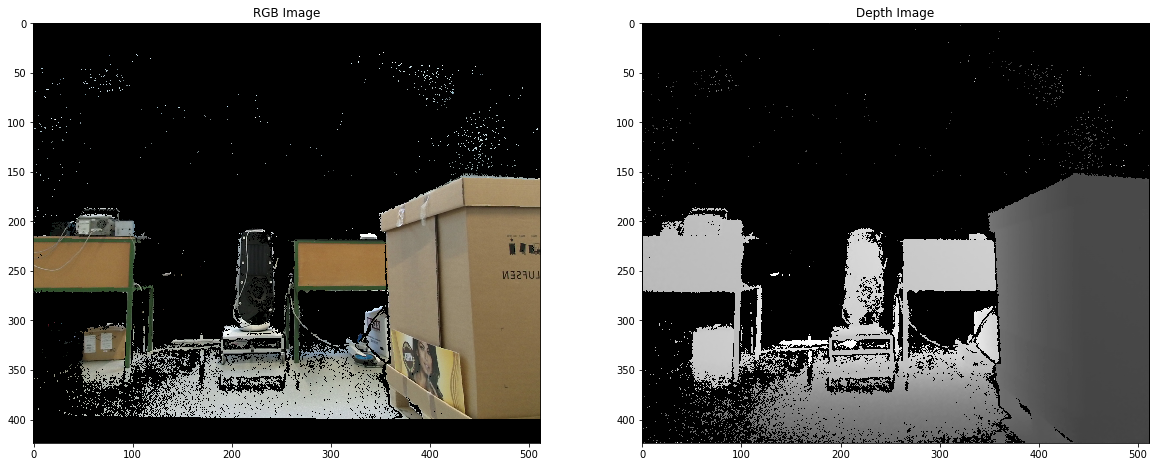

In [15]:
fig, subs = plt.subplots(1, 2, figsize=(20, 8))
subs[0].set_title("RGB Image")
subs[0].imshow(color_image)
subs[1].set_title("Depth Image")
subs[1].imshow(depth_image, cmap='gray')

In [16]:
before = time.time()
num_points = Depth_ResX * Depth_ResY

point_cloud = np.zeros((num_points, 6))
#point_cloud = np.zeros((num_points, 3))
print(point_cloud[0,:])

counter = 0
for x in range(Depth_ResX):
    for y in range(Depth_ResY):
        # Skip invalid points
        if depth_image[y, x] != 0.0:
            point_cloud[counter, 0] = y
            point_cloud[counter, 1] = x
            point_cloud[counter, 2] = -depth_image[y, x] * 255.0 * 1
            #point_cloud[counter, 2] = -np.log(raw_depth_1_channel[x, y]) * 255.0
            #point_cloud[counter, 2] = np.tan(raw_depth_1_channel[x, y]+0.5)
            if depth_image[y, x] != 0:
                point_cloud[counter, 3] = color_image[y, x, 0]
                point_cloud[counter, 4] = color_image[y, x, 1]
                point_cloud[counter, 5] = color_image[y, x, 2]
            else:
                #point_cloud[counter, 2] = 0
                point_cloud[counter, 3] = 0
                point_cloud[counter, 4] = 0
                point_cloud[counter, 5] = 0
            counter += 1
after = time.time()
print("Execution time: {}".format(after-before))

[0. 0. 0. 0. 0. 0.]
Execution time: 0.2610189914703369


In [17]:
before = time.time()

pc2 = np.zeros((num_points, 6))
pc2[:,0] = np.tile(np.arange(0, Depth_ResX), Depth_ResY)
pc2[:,1] = np.tile(np.arange(0, Depth_ResY), Depth_ResX)
pc2[:,3] = depth_image.ravel() * 255.0
pc2[:,3:] = (0, 0, 0)

after = time.time()
print("Execution time: {}".format(after-before))

Execution time: 0.010740280151367188


In [18]:
np.tile(np.arange(0, 2), 3)

array([0, 1, 0, 1, 0, 1])

In [19]:
points = pd.DataFrame(point_cloud, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
points.describe()

,x,y,z,red,green,blue
count,217088.000000,217088.000000,217088.000000,217088.000000,217088.000000,217088.000000
mean,113.335781,117.958869,-47.953876,43.986176,40.496716,32.761300
std,153.829708,175.860837,70.664265,68.907087,64.129469,55.528944
min,0.000000,0.000000,-255.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-81.674817,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,258.000000,260.000000,0.000000,122.000000,104.000000,65.000000
max,423.000000,510.000000,0.000000,255.000000,255.000000,255.000000


In [20]:
points2 = pd.DataFrame(pc2, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
points2.describe()

,x,y,z,red,green,blue
count,217088.000000,217088.000000,217088.0,217088.0,217088.0,217088.0
mean,255.500000,211.500000,0.0,0.0,0.0,0.0
std,147.801727,122.398199,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,127.750000,105.750000,0.0,0.0,0.0,0.0
50%,255.500000,211.500000,0.0,0.0,0.0,0.0
75%,383.250000,317.250000,0.0,0.0,0.0,0.0
max,511.000000,423.000000,0.0,0.0,0.0,0.0


In [21]:
cloud = pc(points)
cloud.plot(IFrame_shape=(1200, 700))